# Experimento 1: Dataset gerado por IA com baixa qualidade

Neste notebook, foi utilizado um dataset gerado por inteligência artificial contendo 2 mil registros, sem controle sobre a variabilidade dos dados nem sobre a correlação entre as variáveis explicativas e o target (limite de crédito).

## Estratégias aplicadas:
- Análise de correlação
- Transformação de variáveis para tentar melhorar a linearidade
- Criação de 16 novas features
- Teste com diferentes algoritmos: Regressão Linear, Árvore de Regressão, Random Forest e KNN

## Resultados:
- Regressão Linear (com features originais):  
  - MSE: 102002771.68  
  - RMSE: 10099.64  
  - MAE: 8213.54  
  - R²: 0.15

- Regressão Linear (com features criadas):  
  - R²: 0.14

- KNN Regressor:  
  - R²: 0.01

> Conclusão: A baixa variabilidade e fraca correlação explicam o desempenho ruim dos modelos, mesmo com tentativas de engenharia de features.


In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor


In [229]:
df = pd.read_csv ('~/Documents/Regressao_credito/dados_emprestimo_simulados.csv')

In [230]:
df.head(10)

,renda_mensal,score_credito,tempo_emprego,inadimplente_passado,num_produtos,tipo_cliente,valor_aprovado
0,5993.428306,582.482173,3.318117,0,4,PF,28468.523341
1,4723.471398,635.548133,0.446359,0,3,PF,29783.935165
2,6295.377076,570.758008,17.960831,0,3,PF,23921.787244
3,8046.059713,619.203847,3.649164,0,3,PJ,38593.692914
4,4531.693251,460.638533,4.762003,0,2,PF,17287.404473
5,4531.726086,671.329371,1.349930,0,4,PF,11344.540265
6,8158.425631,650.120548,3.303381,0,2,PF,8962.651621
7,6534.869458,568.291137,2.803140,0,4,PF,20215.025962
8,4061.051228,715.924567,0.389245,0,1,PJ,5539.914738
9,6085.120087,743.757014,0.561144,0,5,PF,16876.360238


In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   renda_mensal          2000 non-null   float64
 1   score_credito         2000 non-null   float64
 2   tempo_emprego         2000 non-null   float64
 3   inadimplente_passado  2000 non-null   int64  
 4   num_produtos          2000 non-null   int64  
 5   tipo_cliente          2000 non-null   object 
 6   valor_aprovado        2000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 109.5+ KB


In [232]:
df.describe()

# Média e desvio padrão → indicam centralidade e dispersão.

# Mínimo e máximo → destacam possíveis outliers.

#dados parecem bem distribuídos com relação a valores máx, médias e desvio padrão.

,renda_mensal,score_credito,tempo_emprego,inadimplente_passado,num_produtos,valor_aprovado
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,5104.507596,648.534111,4.967129,0.183000,3.050000,25644.551774
std,1942.034595,98.528519,5.017767,0.386763,1.706739,11248.039553
min,1000.000000,348.048784,0.001205,0.000000,1.000000,1000.000000
25%,3754.676197,579.087403,1.395006,0.000000,2.000000,17911.382781
50%,5089.383312,649.994670,3.322434,0.000000,3.000000,25590.493220
75%,6365.955187,716.554368,7.029501,0.000000,4.000000,33206.042192
max,12705.462981,850.000000,37.626017,1.000000,10.000000,71207.003734


In [233]:
df.isnull().sum()

renda_mensal            0
score_credito           0
tempo_emprego           0
inadimplente_passado    0
num_produtos            0
tipo_cliente            0
valor_aprovado          0
dtype: int64

In [234]:
# Usando one-hot encoding para 'tipo_cliente'
df['tipo_cliente'] = df['tipo_cliente'].map({'PF': 0, 'PJ': 1})


# Garantir que 'inadimplente_passado' está como numérico (0 ou 1)
df['inadimplente_passado'] = df['inadimplente_passado'].astype(int)

# Distribuição das variáveis numéricas

- Distribuições normais/truncadas (como renda_mensal, score_credito) favorecem regressão linear, pois geram relações mais suaves.

- Distribuições enviesadas (como tempo_emprego e valor_aprovado) podem indicar a necessidade de transformação logarítmica.

- Contagem de categorias (tipo_cliente) revela desequilíbrio entre classes. Por exemplo, muitos clientes PF e poucos PJ — você pode querer fazer encoding com cuidado ou considerar análise estratificada depois.

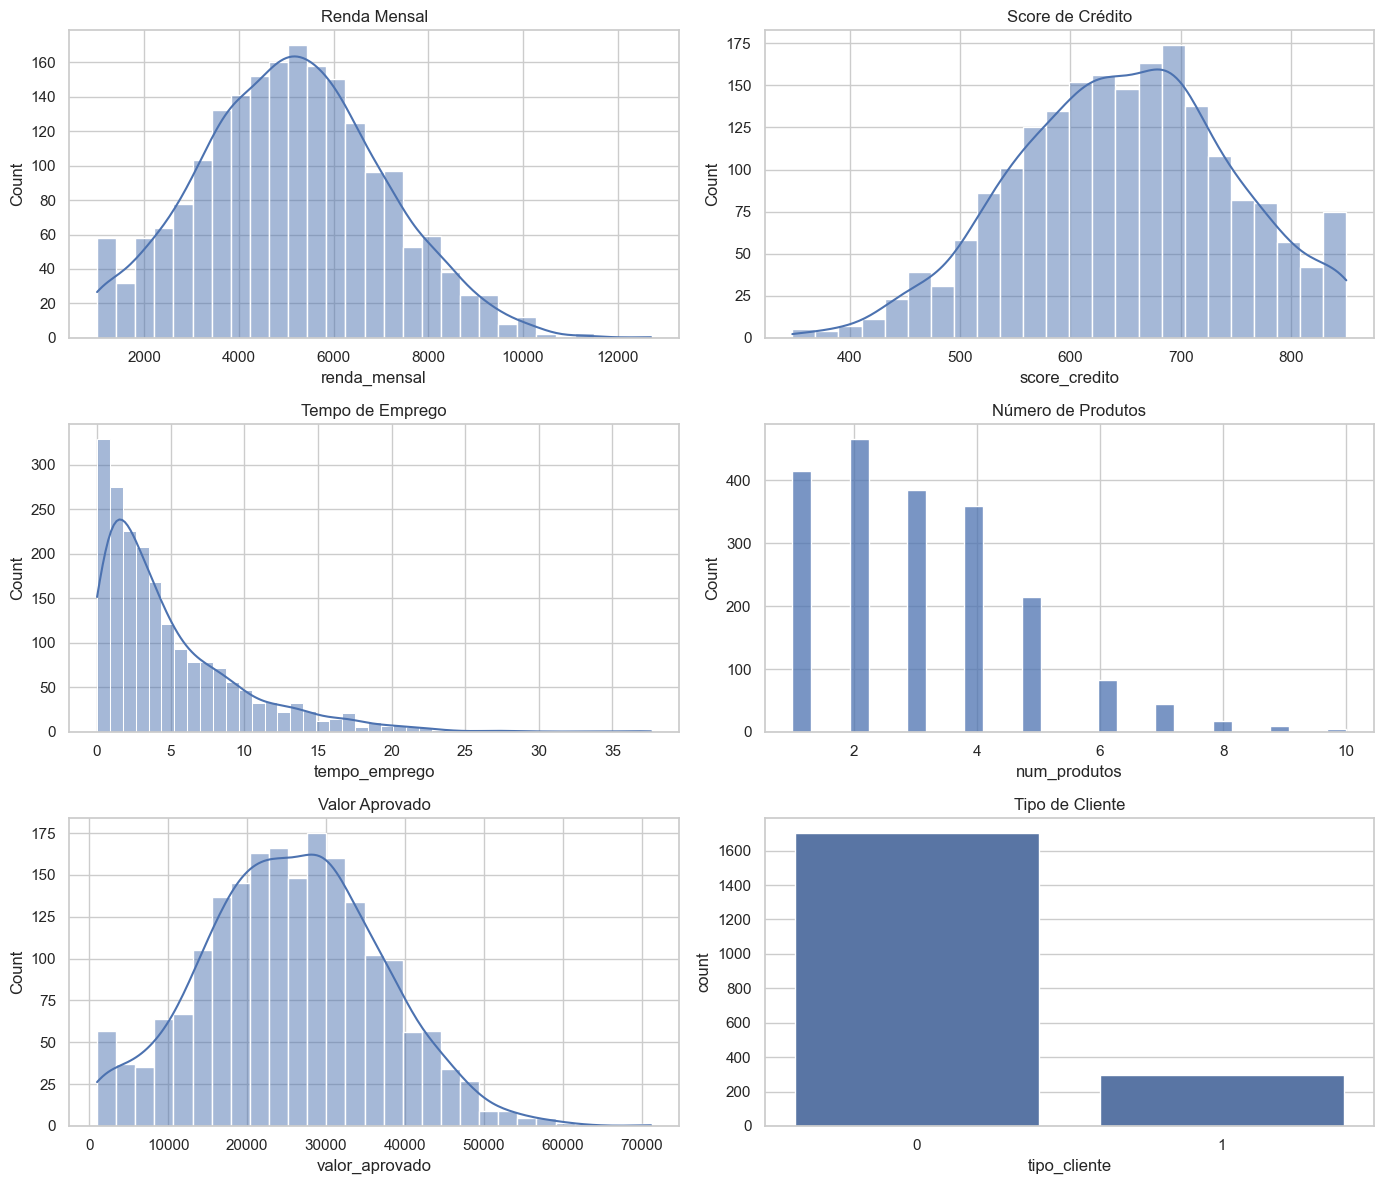

In [235]:

sns.set(style='whitegrid')
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

sns.histplot(df['renda_mensal'], kde=True, ax=axs[0, 0]).set_title("Renda Mensal")
sns.histplot(df['score_credito'], kde=True, ax=axs[0, 1]).set_title("Score de Crédito")
sns.histplot(df['tempo_emprego'], kde=True, ax=axs[1, 0]).set_title("Tempo de Emprego")
sns.histplot(df['num_produtos'], kde=False, ax=axs[1, 1]).set_title("Número de Produtos")
sns.histplot(df['valor_aprovado'], kde=True, ax=axs[2, 0]).set_title("Valor Aprovado")
sns.countplot(x='tipo_cliente', data=df, ax=axs[2, 1]).set_title("Tipo de Cliente")

plt.tight_layout()
plt.show()


Correlação entre variáveis numéricas

Os valores vão de -1 a 1:

Próximo de 1: forte correlação positiva.

Próximo de -1: forte correlação negativa.

Próximo de 0: sem correlação linear.

Procuramos variáveis com alta correlação com o target (valor_aprovado) para priorizar na modelagem: num produtos, inadimplente passado, renda_mensal

Importante evitar multicolinearidade entre as variáveis, que pode atrapalhar a regressão linear: não identifiquei

In [236]:
correlacoes = df.corr(method='pearson')['valor_aprovado'].sort_values(ascending=False)
print(correlacoes)

valor_aprovado          1.000000
tipo_cliente            0.312381
renda_mensal            0.258745
num_produtos            0.140552
tempo_emprego           0.096113
score_credito           0.086824
inadimplente_passado   -0.170172
Name: valor_aprovado, dtype: float64


In [237]:
features = [
    'renda_mensal',
    'score_credito',
    'tempo_emprego',
    'num_produtos',
    'valor_aprovado'
]


# Detectando outliers

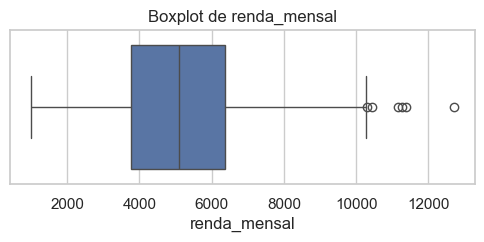

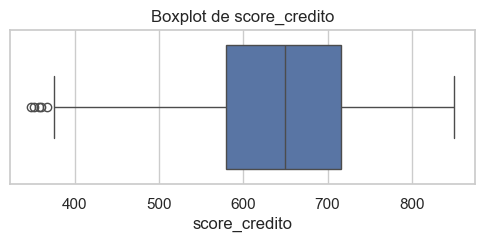

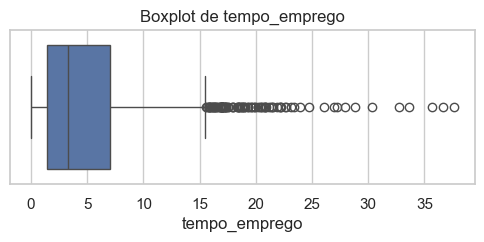

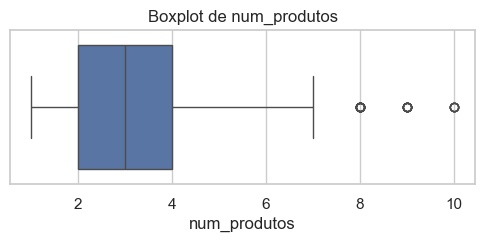

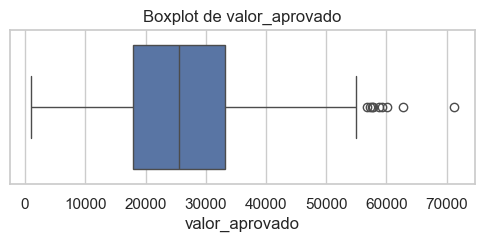

In [238]:
for coluna in features:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=df[coluna])
    plt.title(f"Boxplot de {coluna}")
    plt.show()

# Remoçao de outliers

In [239]:
# Detecção de outliers
outliers_indices = set()

for coluna in features:
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Identificando os índices com outliers
    outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)].index
    outliers_indices.update(outliers)

print(f"Total de registros com pelo menos um outlier: {len(outliers_indices)}")

Total de registros com pelo menos um outlier: 145


In [241]:
# Remoção de outliers
df = df.drop(index=outliers_indices)
print(f"Novo shape do dataset: {df.shape}")

Novo shape do dataset: (1855, 7)


In [243]:
correlacoes = df.corr(method='pearson')['valor_aprovado'].sort_values(ascending=False)
print(correlacoes)

valor_aprovado          1.000000
tipo_cliente            0.309980
renda_mensal            0.264691
num_produtos            0.107064
score_credito           0.090318
tempo_emprego           0.071523
inadimplente_passado   -0.182094
Name: valor_aprovado, dtype: float64


# Analisando remoção de outliers

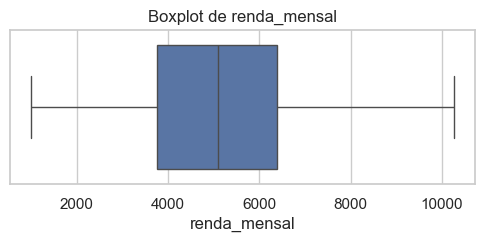

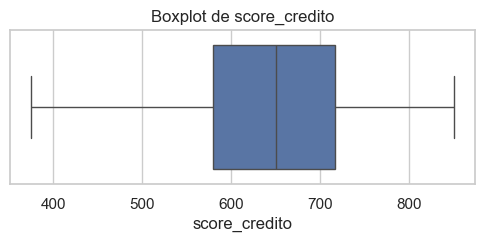

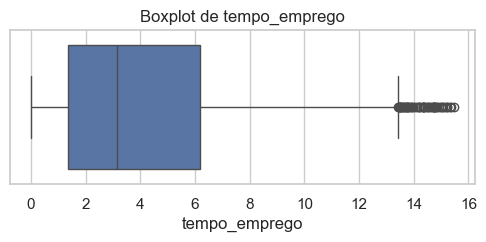

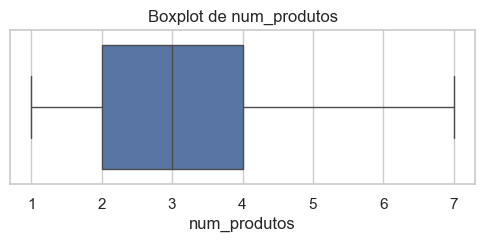

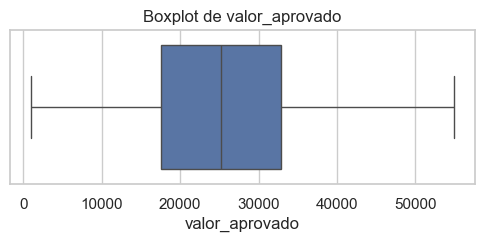

In [244]:
for coluna in features:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=df[coluna])
    plt.title(f"Boxplot de {coluna}")
    plt.show()

# Análise de dispersão

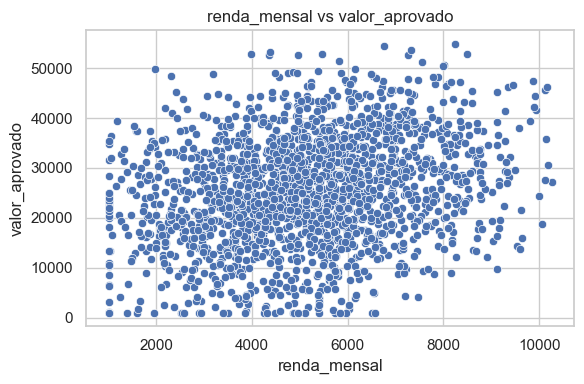

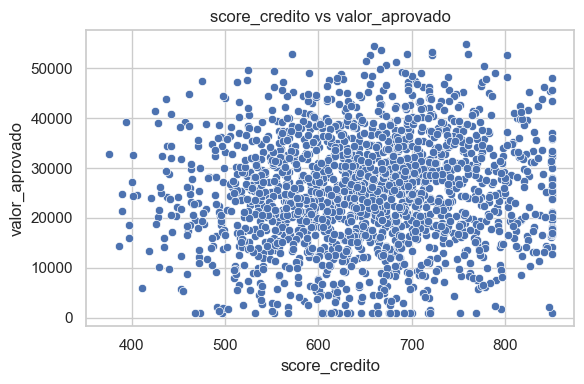

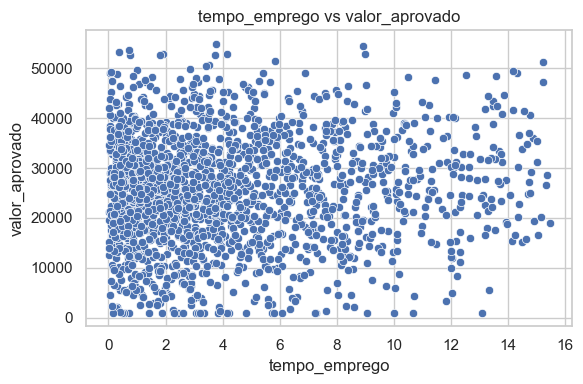

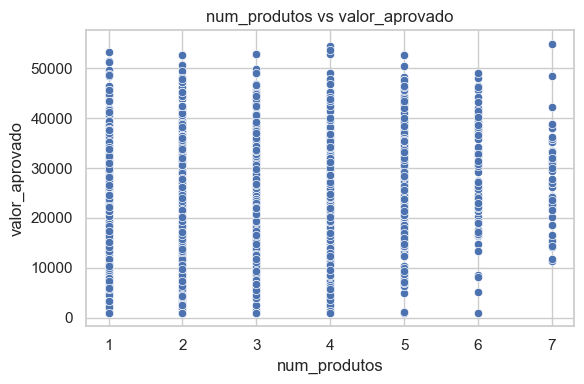

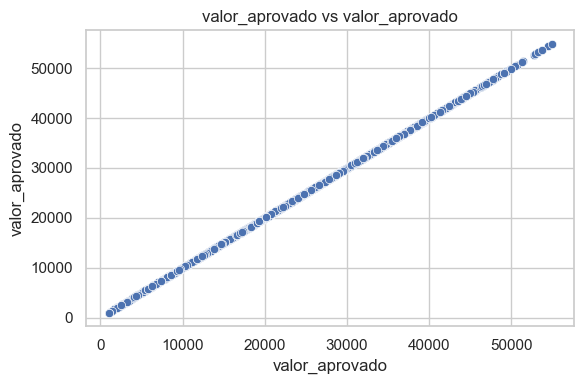

In [245]:
# Plotando os scatterplots
for col in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=col, y='valor_aprovado')
    plt.title(f'{col} vs valor_aprovado')
    plt.xlabel(col)
    plt.ylabel('valor_aprovado')
    plt.tight_layout()
    plt.show()

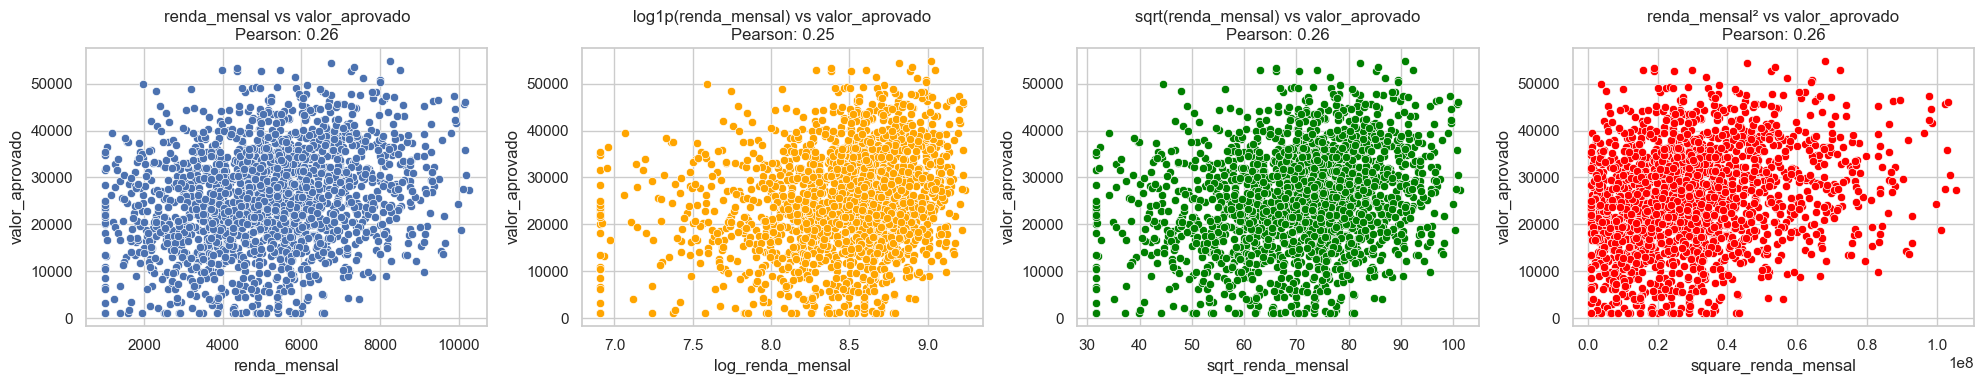

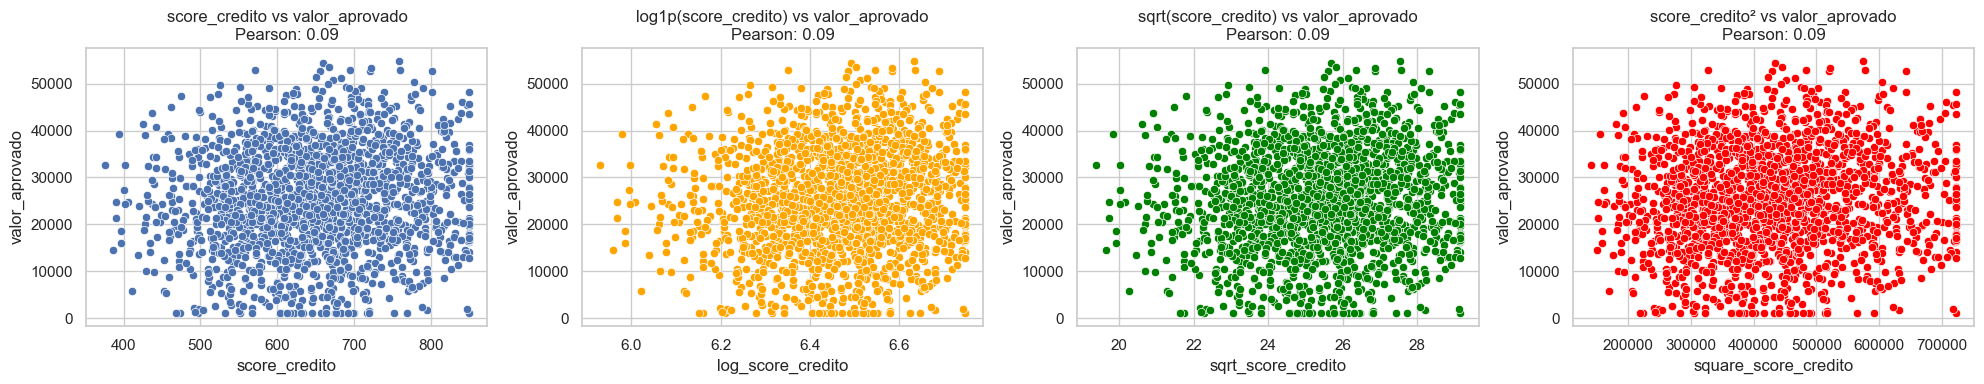

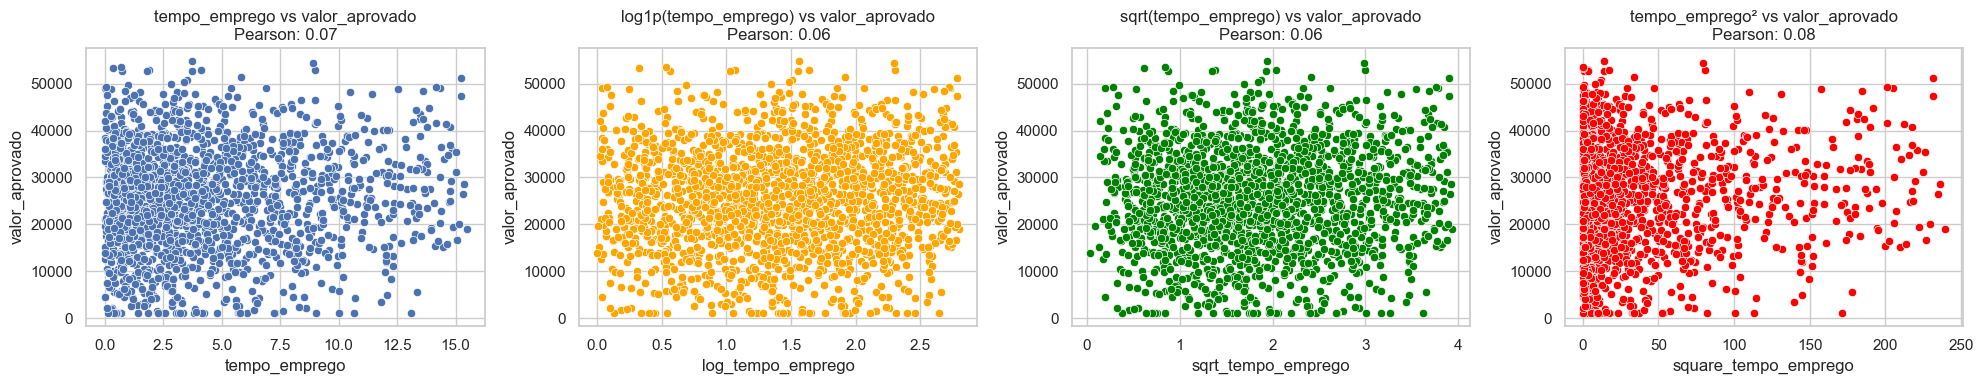

In [246]:
df_transf = df.copy()

# Lista de variáveis numéricas que queremos testar
variaveis = ['renda_mensal', 'score_credito', 'tempo_emprego']

# Variável target
target = 'valor_aprovado'

# Aplicando transformações
for var in variaveis:
    df_transf[f'log_{var}'] = np.log1p(df[var])
    df_transf[f'sqrt_{var}'] = np.sqrt(df[var])
    df_transf[f'square_{var}'] = np.square(df[var])

# Plotando dispersão com a variável target e calculando correlação
for var in variaveis:
    plt.figure(figsize=(20, 4))
    
    # Original
    corr = pearsonr(df[var], df[target])[0]
    plt.subplot(1, 4, 1)
    sns.scatterplot(x=df[var], y=df[target])
    plt.title(f'{var} vs {target}\nPearson: {corr:.2f}')
    
    # log1p
    corr_log = pearsonr(df_transf[f'log_{var}'], df[target])[0]
    plt.subplot(1, 4, 2)
    sns.scatterplot(x=df_transf[f'log_{var}'], y=df[target], color='orange')
    plt.title(f'log1p({var}) vs {target}\nPearson: {corr_log:.2f}')

    # sqrt
    corr_sqrt = pearsonr(df_transf[f'sqrt_{var}'], df[target])[0]
    plt.subplot(1, 4, 3)
    sns.scatterplot(x=df_transf[f'sqrt_{var}'], y=df[target], color='green')
    plt.title(f'sqrt({var}) vs {target}\nPearson: {corr_sqrt:.2f}')
    
    # square
    corr_sq = pearsonr(df_transf[f'square_{var}'], df[target])[0]
    plt.subplot(1, 4, 4)
    sns.scatterplot(x=df_transf[f'square_{var}'], y=df[target], color='red')
    plt.title(f'{var}² vs {target}\nPearson: {corr_sq:.2f}')
    
    plt.tight_layout()
    plt.show()

# Criação de novas features

In [247]:
df['capacidade_estimativa'] = df['renda_mensal'] / (df['num_produtos'] + 1)

df['estabilidade_financeira'] = df['tempo_emprego'] * df['score_credito']

df['cliente_confiavel'] = df['score_credito'] * (1 - df['inadimplente_passado']) * df['tempo_emprego']

df['score_ajustado'] = df['score_credito'] / np.log1p(df['renda_mensal'])

df['indice_endividamento'] = df['num_produtos'] / df['renda_mensal']

df['cliente_solido'] = df['tempo_emprego'] * df['score_credito'] * (1 - df['inadimplente_passado'])

# 1. Interações entre variáveis
df['renda_produtos'] = df['renda_mensal'] * df['num_produtos']
df['capacidade_produtos'] = df['capacidade_estimativa'] * df['num_produtos']
df['score_solido'] = df['score_credito'] * df['cliente_solido']

# 2. Transformações logarítmicas
df['renda_log'] = np.log1p(df['renda_mensal'])

# 3. Diferenças entre variáveis
df['renda_minus_produtos'] = df['renda_mensal'] - df['num_produtos']
df['score_minus_solidez'] = df['score_credito'] - df['cliente_solido']

# 4. Taxas derivadas
df['log_indice_endividamento'] = np.log1p(df['indice_endividamento'])
df['taxa_estabilidade'] = df['tempo_emprego'] / df['score_credito']

# 5. One-Hot Encoding de 'tipo_cliente' (se ainda não foi feito)
df = pd.get_dummies(df, columns=['tipo_cliente'], drop_first=True)

# 6. Variáveis binárias baseadas em limiares
df['score_credito_alto'] = (df['score_credito'] > df['score_credito'].median()).astype(int)

# 7. Combinações de variáveis adicionais
df['confiabilidade_capacidade'] = df['cliente_confiavel'] * df['capacidade_estimativa']

# Verificar correlação com a variável alvo
correlacoes = df.corr(method='pearson')['valor_aprovado'].sort_values(ascending=False)
print(correlacoes)


valor_aprovado               1.000000
tipo_cliente_1               0.309980
capacidade_produtos          0.273202
renda_mensal                 0.264691
renda_minus_produtos         0.264606
renda_log                    0.251266
renda_produtos               0.230878
confiabilidade_capacidade    0.153152
score_solido                 0.140921
cliente_confiavel            0.140021
cliente_solido               0.140021
capacidade_estimativa        0.109236
num_produtos                 0.107064
score_credito_alto           0.090453
score_credito                0.090318
estabilidade_financeira      0.081473
tempo_emprego                0.071523
taxa_estabilidade            0.056792
score_ajustado              -0.003526
indice_endividamento        -0.089589
log_indice_endividamento    -0.089591
score_minus_solidez         -0.137237
inadimplente_passado        -0.182094
Name: valor_aprovado, dtype: float64


# Split de dados - Originais

In [248]:
#X = df.drop(columns=['valor_aprovado']) 
X = df.drop(columns=['valor_aprovado', 'estabilidade_financeira', 'cliente_confiavel', 'score_ajustado', 'indice_endividamento', 'cliente_solido'])
y = df['valor_aprovado']

In [249]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [250]:
#escalonamento dos dados
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)


# Treinamento e Avaliação

In [251]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Previsões
y_pred = lr.predict(X_test_scaled)

In [252]:
# Regressão Linear 
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 102002771.68101119
RMSE: 10099.642156087075
MAE: 8213.544735479523
R²: 0.15123293075955757


# Treinamento regressão linear + novas variáveis

In [253]:
# Seleção de variáveis com as novas variáveis

X_completo = df.drop(columns=['valor_aprovado'])

# Separando em treino e teste
X_train_completo, X_test_completo, _, _ = train_test_split(X_completo, y, test_size=0.2, random_state=42)

In [254]:
X_train_completo_scaled = scaler.fit_transform(X_train_completo)
X_test_completo_scaled = scaler.transform(X_test_completo)

In [255]:
# Treinando o modelo com as variáveis novas
lr.fit(X_train_completo_scaled, y_train)

# Previsões
y_pred_completo = lr.predict(X_test_completo_scaled)

In [256]:
# Regressão Linear 
print("MSE:", mean_squared_error(y_test, y_pred_completo))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_completo)))
print("MAE:", mean_absolute_error(y_test, y_pred_completo))
print("R²:", r2_score(y_test, y_pred_completo))


MSE: 102830335.26183309
RMSE: 10140.529338344872
MAE: 8246.16497807389
R²: 0.1443467579278923


# Treinamento outros Algoritmos

In [257]:
# Árvore de Regressão
tree = DecisionTreeRegressor(max_depth=10, min_samples_leaf=100,random_state=42)
tree.fit(X_train_scaled, y_train)
y_pred_tree = tree.predict(X_test_scaled)

In [258]:
print("MSE:", mean_squared_error(y_test, y_pred_tree))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_tree)))
print("MAE:", mean_absolute_error(y_test, y_pred_tree))
print("R²:", r2_score(y_test, y_pred_tree))

MSE: 102633458.57382974
RMSE: 10130.817270774838
MAE: 8219.71354747669
R²: 0.14598497272073097


In [259]:
# KNN Regressor
knn = KNeighborsRegressor(n_neighbors=70, weights= 'distance') # metric ='euclidean', 'manhattan', 'minkowski'
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

In [260]:
print("MSE:", mean_squared_error(y_test, y_pred_knn))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_knn)))
print("MAE:", mean_absolute_error(y_test, y_pred_knn))
print("R²:", r2_score(y_test, y_pred_knn))

MSE: 118293389.20756343
RMSE: 10876.276440379926
MAE: 8745.059623029963
R²: 0.015678381934461694


In [261]:
# Criando e treinando o modelo Random Forest
rf = RandomForestRegressor(n_estimators=1000, max_depth =7, random_state=42)
rf.fit(X_train_scaled, y_train)
# Fazendo previsões
y_pred_rf = rf.predict(X_test_scaled)


In [262]:

# Calculando as métricas
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

MSE: 102762188.05515961
RMSE: 10137.16864095491
MAE: 8205.079904598993
R²: 0.14491381217486954
